In [39]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Convolution2D, MaxPooling2D, Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam, SGD
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler
import math
import random
import pandas

#Gernate Data
def data_generator():
    vel_data = np.random.uniform(1,100,size=50000).astype(np.float32)
    ang_data = np.random.uniform(1,89,size=50000).astype(np.float32)
    rad_data = np.radians(ang_data)
    H_data = (vel_data**2)*(np.sin(rad_data)**2)/(2*9.8)
    R_data = (vel_data**2)*(np.sin(rad_data*2))/9.8
    return vel_data, rad_data, H_data, R_data

vel_data, rad_data, H_data, R_data = data_generator()
train_data = {'Velocity': vel_data, 'Theta': rad_data, 'Height': H_data, 'Range': R_data}
X = np.stack((vel_data,rad_data),axis = 1)
Y = np.stack((H_data,R_data),axis = 1)

In [40]:
#Build Model
epochs = 100
model = Sequential([
Dense(252, activation = 'relu', input_shape=(2, )),
Dense(126, activation ='relu'),
Dense(64, activation = 'relu'),
Dense(32, activation = 'relu'),
Dense(2, activation = 'relu')])
model.compile(loss='mae', optimizer= Adam(learning_rate = 0.03/epochs), metrics= ['accuracy']) #metrics=['accuracy']
print(model.summary())

#Training with cross-validation (K-Fold)
k = 10
kf = KFold(n_splits = k, shuffle = True, random_state = 42)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index,:], X[test_index,:]
    Y_train, Y_test = Y[train_index,:], Y[test_index,:]
    X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size = 0.2)
    #Normalization
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_val = scaler.transform(X_val)
    results = model.fit(X_train,Y_train,batch_size=2048,epochs=epochs,validation_data=(X_val,Y_val))
    preds = model.predict(X_test)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 252)               756       
_________________________________________________________________
dense_31 (Dense)             (None, 126)               31878     
_________________________________________________________________
dense_32 (Dense)             (None, 64)                8128      
_________________________________________________________________
dense_33 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_34 (Dense)             (None, 2)                 66        
Total params: 42,908
Trainable params: 42,908
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
22/22 [==============================] - 0s 20ms/step - loss: 154.7479 - accuracy: 0.2352 - val_los

In [41]:
for i in range(5):
    vel = np.random.uniform(1,100)
    ang = np.random.uniform(1,89)
    rad = np.radians(ang)
    temp = [[vel, rad]]
    temp = np.asarray(temp)
    temp = scaler.transform(temp)
    preds = model.predict(temp)
    H = (vel**2)*(np.sin(rad)**2)/(2*9.8)
    R = (vel**2)*(np.sin(rad*2))/9.8
    print("Original: ", H, R)
    print("Predicted: ", preds)

Original:  20.55292354055787 36.99489404575915
Predicted:  [[21.08864  37.387764]]
Original:  0.3289487174414473 7.3340037245411605
Predicted:  [[0.29463345 7.349047  ]]
Original:  0.5006146784110181 14.40939286844635
Predicted:  [[ 0.40255648 14.2710285 ]]
Original:  42.74866466621748 331.5332644699542
Predicted:  [[ 42.873505 331.1281  ]]
Original:  284.00454485624704 459.7763399587203
Predicted:  [[284.12805 459.183  ]]


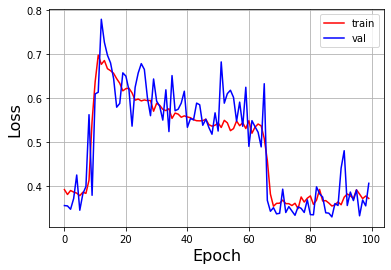

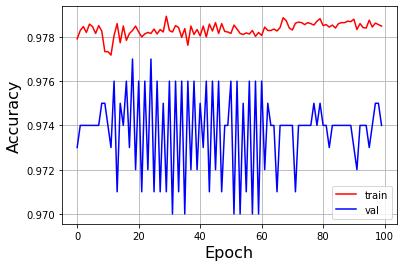

In [42]:
#Lauch the Graph
fig = plt.figure()
plt.plot(results.history['loss'], 'r', label='train')
plt.plot(results.history['val_loss'], 'b', label='val')
plt.xlabel(r'Epoch', fontsize=16)
plt.ylabel(r'Loss', fontsize=16)
plt.grid(True)
plt.legend()
plt.show()
fig.savefig('Loss.png')
plt.close()
fig = plt.figure()
plt.plot(results.history['accuracy'], 'r', label='train')
plt.plot(results.history['val_accuracy'], 'b', label='val')
plt.xlabel(r'Epoch', fontsize=16)
plt.ylabel(r'Accuracy', fontsize=16)
plt.grid(True)
plt.legend()
plt.show()
fig.savefig('Accuracy.png')
plt.close()

隨機產生速度與角度，比較公式與預測的高度
高度共變異數： 12421.836745122591
公式高度標準差： 111.41874836133088
預測高度標準差： 111.48837468584247
Pearson Correlation Coefficient:  0.9999952970772744
迴歸直線：y = 1.00062 x + 0.00706
線性迴歸下的R-squared： 0.9999905941769964


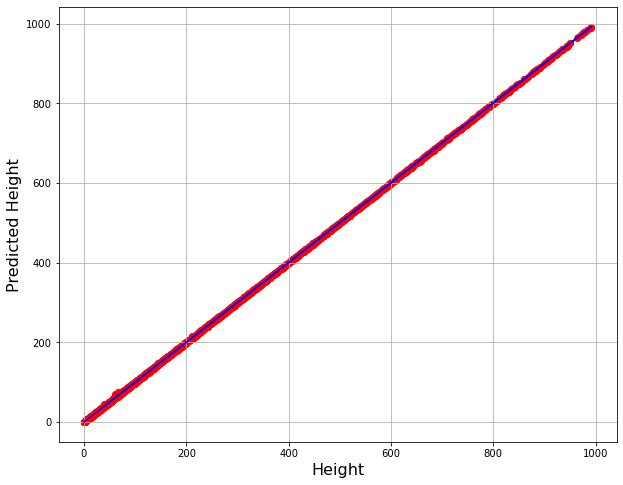

In [43]:
from sklearn.metrics import r2_score

Velocity = []
Angle = []
Height = []
pre_Height = []
Range = []
pre_Range = []
for i in range(3000):
    vel = np.random.uniform(1,100)
    ang = np.random.uniform(1,89)
    Angle.append(ang)
    Velocity.append(vel)    
    rad = np.radians(ang)
    temp = [[vel, rad]]
    temp = np.asarray(temp)
    temp = scaler.transform(temp)
    preds = model.predict(temp)
    pre_Height.append(preds[0][0])
    pre_Range.append(preds[0][1])
    H = (vel**2)*(np.sin(rad)**2)/(2*9.8)
    R = (vel**2)*(np.sin(rad*2))/9.8
    Height.append(H)
    Range.append(R) 

def average(L):
    return sum(L)/len(L)

# 共變異數
def cov(X,Y):
    assert len(X)==len(Y), "Lengths of array X and Y are not equal."
    aveX,aveY= average(X),average(Y)
    return average([(X[i]-aveX)*(Y[i]-aveY) for i in range(len(X))])

# 標準差
def std(L):
    mean = average(L)
    L2 = [(y-mean)**2 for y in L]
    return math.sqrt(average(L2))

def rho(X,Y):
    return cov(X,Y)/(std(X)*std(Y))   

print("隨機產生速度與角度，比較公式與預測的高度")
print("高度共變異數：", cov(Height,pre_Height))
print("公式高度標準差：", std(Height))
print("預測高度標準差：", std(pre_Height))
print("Pearson Correlation Coefficient: ", rho(Height,pre_Height))
    
fig = plt.figure(figsize = (10, 8))
plt.xlabel("Height", fontsize=16)
plt.ylabel("Predicted Height", fontsize=16)
f = np.poly1d(np.polyfit(Height, pre_Height, 1))
plt.plot(Range,f(Range), c = 'b') #畫迴歸直線
plt.scatter(Range,pre_Range, c = 'r')
print("迴歸直線：y =", round(f[1],5), "x +", round(f[0],5))
print("線性迴歸下的R-squared：",r2_score(pre_Height, f(Height)))
plt.grid(True)
plt.show() #顯示繪製的圖形

隨機產生速度與角度，比較公式與預測的距離
距離共變異數： 61419.98729283952
公式距離標準差： 247.8659618636159
預測距離標準差： 247.79650265028678
Pearson Correlation Coefficient:  0.9999946079241842
R-squared from Linear Regression: 0.9999892158775224
迴歸直線：y = 0.99971 x + -0.19385


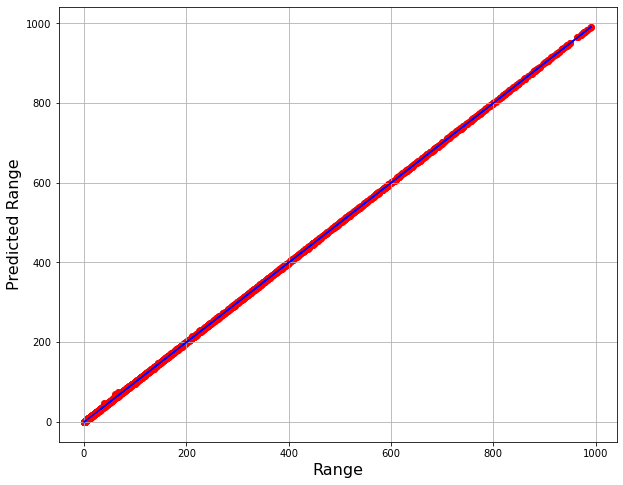

In [44]:
print("隨機產生速度與角度，比較公式與預測的距離")
print("距離共變異數：", cov(Range,pre_Range))
print("公式距離標準差：", std(Range))
print("預測距離標準差：", std(pre_Range))
print("Pearson Correlation Coefficient: ", rho(Range,pre_Range))
    
fig = plt.figure(figsize = (10, 8))
plt.xlabel("Range", fontsize=16)
plt.ylabel("Predicted Range", fontsize=16) 
f = np.poly1d(np.polyfit(Range, pre_Range, 1))
plt.plot(Range,f(Range), c = 'b') #畫迴歸直線
plt.scatter(Range,pre_Range, c = 'r')
print("R-squared from Linear Regression:",r2_score(pre_Range, f(Range)))
print("迴歸直線：y =", round(f[1],5), "x +", round(f[0],5))
plt.grid(True)
plt.show() #顯示繪製的圖形